In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
%matplotlib inline

from scipy.stats import boxcox
from scipy.stats.mstats import normaltest

from sklearn.preprocessing import StandardScaler,LabelEncoder,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

In [2]:
salary_df = pd.read_csv("clean_data.csv")

In [3]:
salary_df.head()

,ResponseId,Employment,EdLevel,YearsCodePro,WorkExp,Age,Gender,OrgSize,Country,Salary
0,13,"Employed, full-time",Bachelors,5.0,5.0,25-34,Man,Micro enterprise,United States of America,65000.0
1,22,"Employed, full-time",Masters,4.0,4.0,25-34,Man,Micro enterprise,Italy,34126.0
2,23,"Employed, full-time",Undergraduate,20.0,23.0,35-44,Man,Small enterprise,Canada,97605.0
3,26,"Employed, full-time",Masters,9.0,9.0,25-34,Man,Micro enterprise,Germany,90647.0
4,52,"Employed, full-time",Bachelors,3.0,3.0,25-34,Man,Micro enterprise,Poland,38856.0


In [4]:
salary_df.shape

(8598, 10)

## Correlation 

In [5]:
salary_num   = salary_df.select_dtypes(include = ['float64', 'int64','int32'])
salary_corr  = salary_num.corr()['Salary'][:-1]
top_features = salary_corr[abs(salary_corr) > 0.0].sort_values(ascending = False)
print("There are {} correlated with deathrate: \n{}".format(len(top_features),top_features))

There are 3 correlated with deathrate: 
YearsCodePro    0.060092
WorkExp         0.057090
ResponseId     -0.003659
Name: Salary, dtype: float64


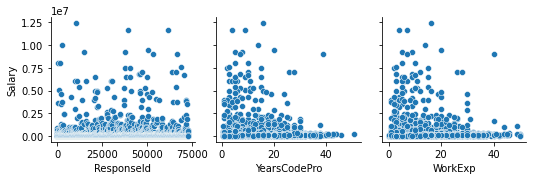

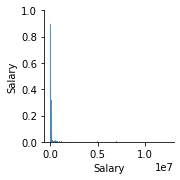

In [6]:
for i in range(0, len(salary_num.columns), 3):
    sns.pairplot(data=salary_num,
                x_vars=salary_num.columns[i:i+3],
                y_vars=['Salary'])

## Data Normalization

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


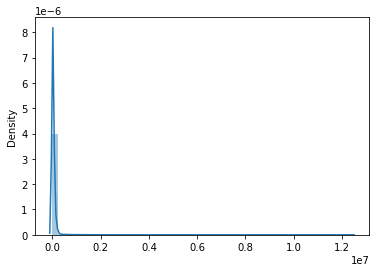

In [7]:
salary = sns.distplot(salary_df.select_dtypes(include = ['float64', 'int64','int32']))

In [8]:
salary_skew = salary_df.skew()
salary_skew

C:\Users\Anchal\AppData\Local\Temp\ipykernel_14112\894782853.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  salary_skew = salary_df.skew()


ResponseId      -0.078205
YearsCodePro     1.428095
WorkExp          1.394046
Salary          11.338434
dtype: float64

In [9]:
skewed_cols = salary_skew[abs(salary_df.skew())>0.5]
print("There are {} skewed : \n{}".format(len(skewed_cols),skewed_cols))

There are 3 skewed : 
YearsCodePro     1.428095
WorkExp          1.394046
Salary          11.338434
dtype: float64


C:\Users\Anchal\AppData\Local\Temp\ipykernel_14112\3049789070.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skewed_cols = salary_skew[abs(salary_df.skew())>0.5]


In [10]:
from scipy.stats import boxcox
def skew(x):
    print("Before transformation: ", salary_df[x].skew())
    salary_df[x] = np.log(salary_df[x])
    print("After transformation: ", salary_df[x].skew())
    return sns.distplot(salary_df[x])

Before transformation:  11.33843440730045
After transformation:  -0.8255999141115484


C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Salary', ylabel='Density'>

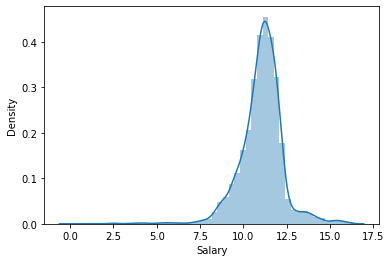

In [11]:
skew('Salary')

In [12]:
def skew_sqrt(x):
    print("Before transformation: ", salary_df[x].skew())
    salary_df[x] = np.sqrt(salary_df[x])
    print("After transformation: ", salary_df[x].skew())
    return sns.distplot(salary_df[x])

Before transformation:  1.428095105232264
After transformation:  0.5094855493710806


C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='YearsCodePro', ylabel='Density'>

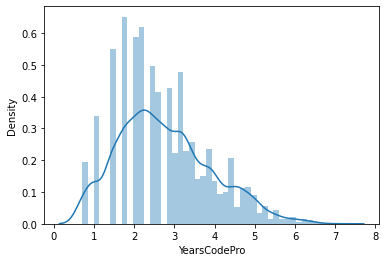

In [13]:
skew_sqrt('YearsCodePro')

Before transformation:  1.394045713234074
After transformation:  0.4724982190451456


C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='WorkExp', ylabel='Density'>

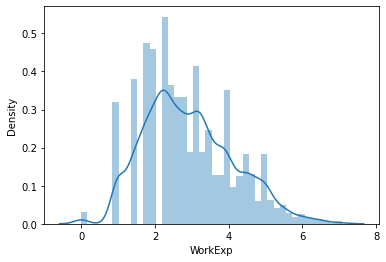

In [14]:
skew_sqrt('WorkExp')

## Testing Assumption for Linear Regression

### 1. Linearity Assumption

<AxesSubplot:xlabel='WorkExp', ylabel='Salary'>

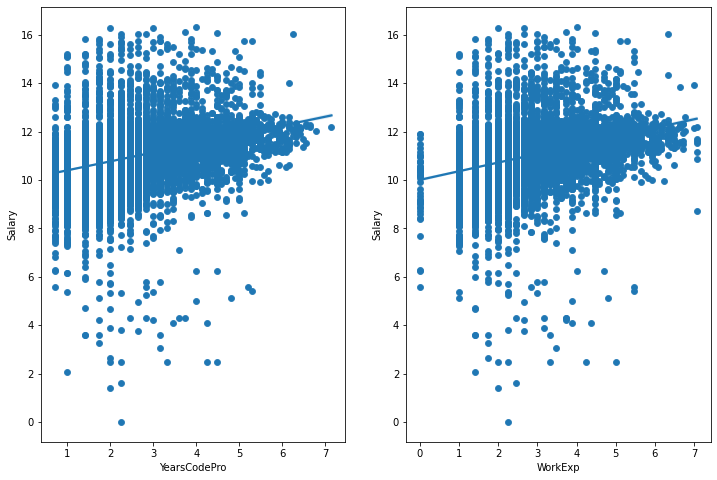

In [15]:
fig, (ax1, ax2) = plt.subplots(figsize = (12,8), ncols=2,sharey=False)
sns.scatterplot(x = salary_df['YearsCodePro'], y = salary_df.Salary, ax = ax1)
sns.regplot(x = salary_df['YearsCodePro'], y = salary_df.Salary, ax = ax1)

sns.scatterplot(x = salary_df['WorkExp'], y = salary_df.Salary, ax = ax2)
sns.regplot(x = salary_df['WorkExp'], y = salary_df.Salary, ax = ax2)

### 2. Homoscedasticity

<AxesSubplot:xlabel='YearsCodePro', ylabel='Salary'>

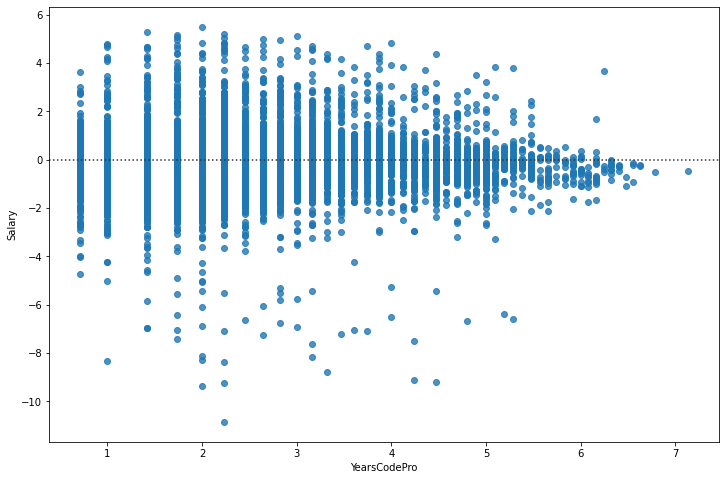

In [16]:
plt.subplots(figsize = (12,8))
sns.residplot(x=salary_df["YearsCodePro"], y=salary_df["Salary"])

<AxesSubplot:xlabel='WorkExp', ylabel='Salary'>

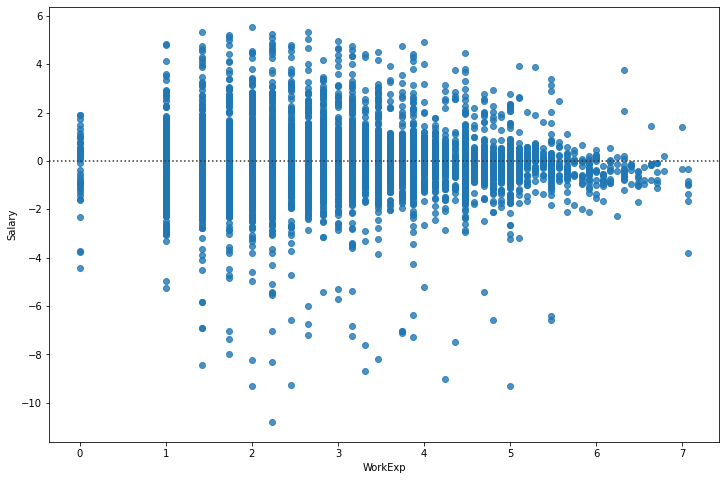

In [17]:
plt.subplots(figsize = (12,8))
sns.residplot(x=salary_df["WorkExp"], y=salary_df["Salary"])


### 3. Normality

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


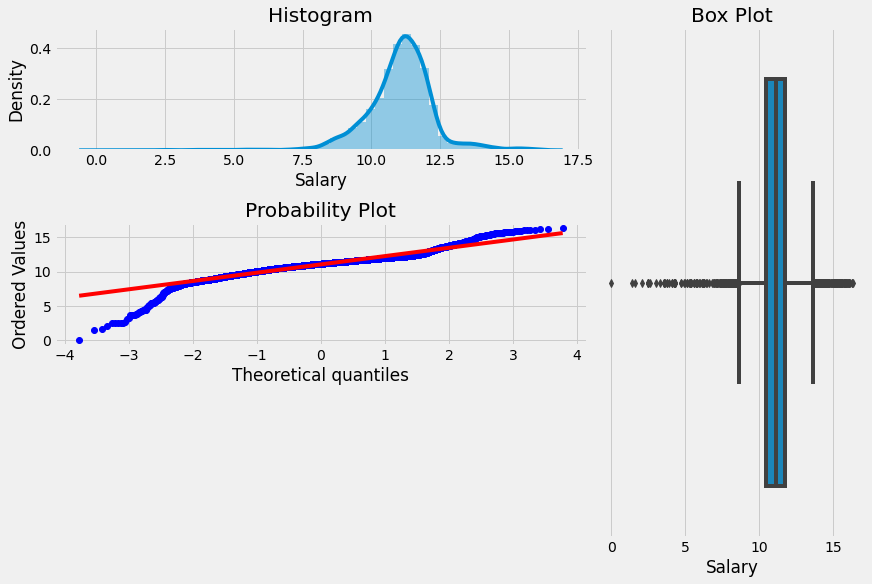

In [18]:
def plotting_3_chart(data, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(salary_df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(salary_df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(salary_df.loc[:,feature], orient='v', ax = ax3);
    
plotting_3_chart(salary_df, 'Salary')

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Salary'>

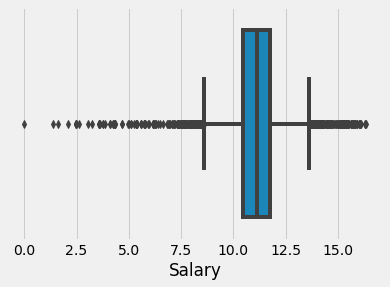

In [19]:
sns.boxplot(salary_df['Salary'])

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Salary'>

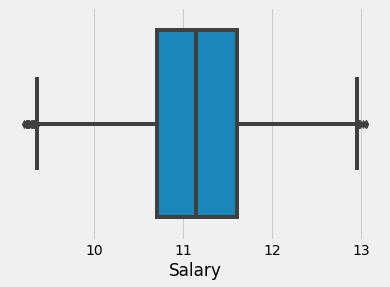

In [29]:
for i in salary_df['Salary']:
    q1 = salary_df['Salary'].quantile(0.25)
    q3 = salary_df['Salary'].quantile(0.75)
    iqr = q3-q1
    low_lim = q1 - 1.5*iqr
    up_lim  = q3 + 1.5*iqr
    if i> up_lim or i< low_lim:
        salary_df['Salary'] = salary_df['Salary'].replace(i,np.mean(salary_df['Salary']))
sns.boxplot(salary_df['Salary'])

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


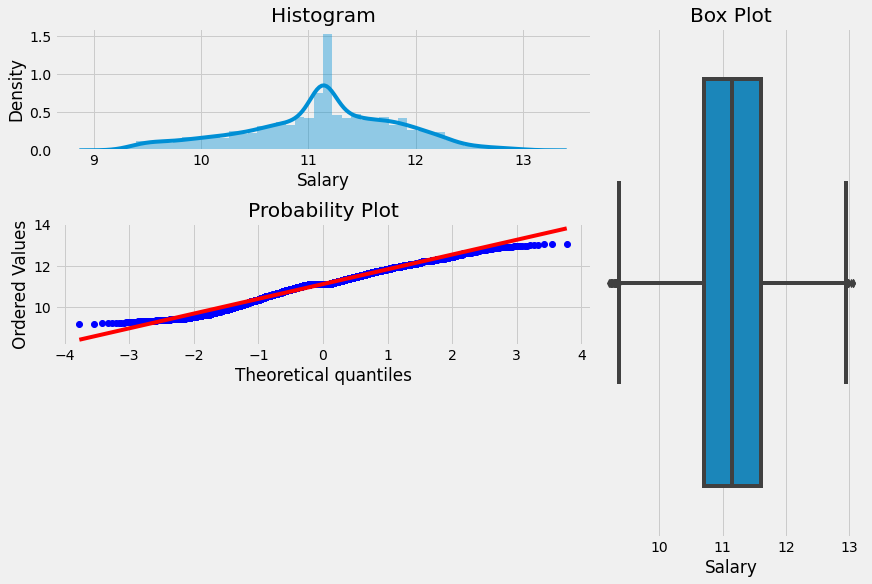

In [30]:
plotting_3_chart(salary_df, 'Salary')

### 4. Multicollinearity

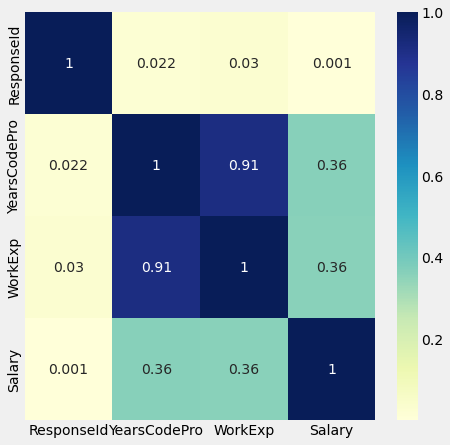

In [31]:
# Enter your code and run the cell
plt.figure(figsize = (7, 7))
sns.heatmap(salary_df.corr(), annot = True, cmap="YlGnBu")
plt.show()

## Data Encoding

In [32]:
salary_df.dtypes[salary_df.dtypes == np.object] 

C:\Users\Anchal\AppData\Local\Temp\ipykernel_14112\1278131524.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  salary_df.dtypes[salary_df.dtypes == np.object]


Employment    object
EdLevel       object
Age           object
Gender        object
OrgSize       object
Country       object
dtype: object

In [33]:
def encoding(x):
    encoder = LabelEncoder()
    print("Before encoding: ",salary_df[x].unique())
    salary_df[x] = encoder.fit_transform(salary_df[x])
    print("After encoding: ")
    return salary_df[x].unique()

In [35]:
encoding('EdLevel')

encoding('OrgSize')

encoding('Country')

encoding('Age')

encoding('Gender')


Before encoding:  [0 1 3 2]
After encoding: 
Before encoding:  [3 4 2 1 0]
After encoding: 
Before encoding:  [130  56  20  41  95  86  81 131 111  39 128 114  50  43  64 119  23  16
  55  29 134  96 123   5  31 115  38 126  74  48  11  15  66   6 124  25
  36  77 107  26 109  33  51  88  65  58   3  47  34  82  22  59   7 112
 106  52 110   9 117 105 103 101  70 108  17  98  67 100 127  94 118  60
 120 129  99  75  10  79  61  53  62  84   4  24 102  80  27  14  40  91
  49   0  46   8  76  92  93 133  18 125  83  42 121  72  37  54  32  78
  87 116  63  90 113 135   1  21  12 104  28  19 122  68  57  35  44   2
  69  97  45  73  89  85 132  30  71  13]
After encoding: 
Before encoding:  [1 2 0 4 3 5 6]
After encoding: 
Before encoding:  [0 2 1]
After encoding: 


array([0, 2, 1], dtype=int64)

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='YearsCodePro'>

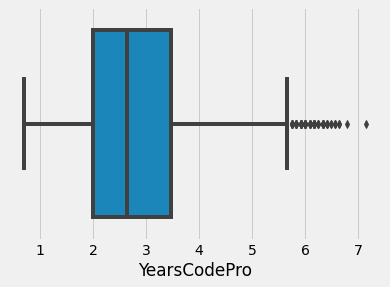

In [37]:
sns.boxplot(salary_df['YearsCodePro'])

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='YearsCodePro'>

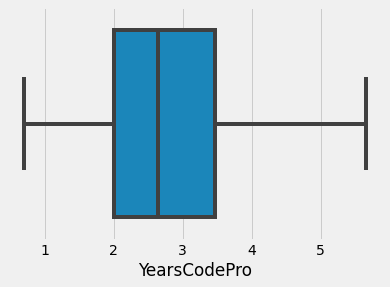

In [38]:
for i in salary_df['YearsCodePro']:
    q1 = salary_df['YearsCodePro'].quantile(0.25)
    q3 = salary_df['YearsCodePro'].quantile(0.75)
    iqr = q3-q1
    low_lim = q1 - 1.5*iqr
    up_lim  = q3 + 1.5*iqr
    if i> up_lim or i< low_lim:
        salary_df['YearsCodePro'] = salary_df['YearsCodePro'].replace(i,np.mean(salary_df['YearsCodePro']))
sns.boxplot(salary_df['YearsCodePro'])

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='WorkExp'>

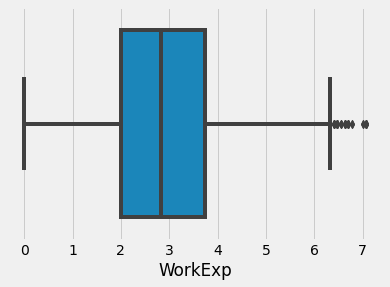

In [39]:
sns.boxplot(salary_df['WorkExp'])

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='WorkExp'>

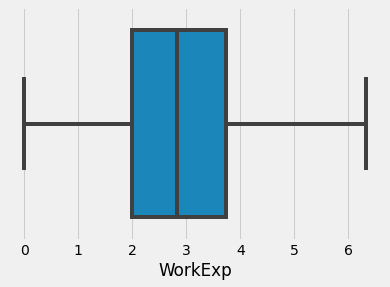

In [40]:
for i in salary_df['WorkExp']:
    q1 = salary_df['WorkExp'].quantile(0.25)
    q3 = salary_df['WorkExp'].quantile(0.75)
    iqr = q3-q1
    low_lim = q1 - 1.5*iqr
    up_lim  = q3 + 1.5*iqr
    if i> up_lim or i< low_lim:
        salary_df['WorkExp'] = salary_df['WorkExp'].replace(i,np.mean(salary_df['WorkExp']))
sns.boxplot(salary_df['WorkExp'])

In [41]:
salary_df.to_csv('clean_data.csv')